Using keras.rnn to Predict Sin()
====

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Avoid 'Blas GEMM launch failed'
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
keras.backend.set_session(tf.Session(config=config))

In [3]:
HIDDEN_SIZE = 30
NUM_LAYERS = 2
TIMESTEPS = 10
BATCH_SIZE = 32
TRAINING_EXAMPLES = 10000
TESTING_EXAMPLES = 1000
SAMPLE_GAP = 0.01
NUM_EPOC = 50

## Using imeseriesGenerator To Generator Time Series For Training
Here each training data contains TIMESTEPS consecutive data samples, and the TIMESTEP+! data as the label.
Take care of the input shape for keras LSTM layer.

In [4]:
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_data = np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32))
train_data = train_data.reshape(-1, 1)
gen_train_data = keras.preprocessing.sequence.TimeseriesGenerator(
    train_data[:TRAINING_EXAMPLES], train_data[TIMESTEPS:], length=TIMESTEPS, 
    batch_size=BATCH_SIZE, shuffle=True
)
print('-------------')
print(*gen_train_data[0])

-------------
[[[-0.5424142 ]
  [-0.5339843 ]
  [-0.52550095]
  [-0.5169651 ]
  [-0.5083775 ]
  [-0.4997456 ]
  [-0.4910572 ]
  [-0.48231962]
  [-0.47353384]
  [-0.46470064]]

 [[ 0.20517704]
  [ 0.1953776 ]
  [ 0.18556236]
  [ 0.17572482]
  [ 0.1658697 ]
  [ 0.15600175]
  [ 0.14611444]
  [ 0.1362125 ]
  [ 0.12630072]
  [ 0.11637253]]

 [[-0.00580826]
  [ 0.00419383]
  [ 0.01419551]
  [ 0.02419576]
  [ 0.03419359]
  [ 0.04418038]
  [ 0.05417037]
  [ 0.06415495]
  [ 0.0741331 ]
  [ 0.08410384]]

 [[-0.24336052]
  [-0.23364708]
  [-0.22391771]
  [-0.2141585 ]
  [-0.20437787]
  [-0.1945768 ]
  [-0.18475626]
  [-0.17491725]
  [-0.16506073]
  [-0.15519524]]

 [[ 0.9950897 ]
  [ 0.99404997]
  [ 0.992911  ]
  [ 0.99167275]
  [ 0.99033505]
  [ 0.9888986 ]
  [ 0.98736286]
  [ 0.98572874]
  [ 0.98399603]
  [ 0.98216456]]

 [[-0.64640135]
  [-0.63873756]
  [-0.6310113 ]
  [-0.623222  ]
  [-0.61536884]
  [-0.6074556 ]
  [-0.59948015]
  [-0.5914462 ]
  [-0.58335316]
  [-0.5752002 ]]

 [[-0.39906967

## Build rnn model
Here we use two lstm layers with one FC layer to generate a single output.
CuDNNLSTM is used for better performance on GPU.
mode.fit_generator is used to accept input series for a generator.
Using early_stopping to perform a quickly training.

In [5]:
model = keras.Sequential()
model.add(keras.layers.CuDNNLSTM(units=HIDDEN_SIZE, input_shape=(TIMESTEPS, 1), return_sequences=True))
model.add(keras.layers.CuDNNLSTM(units=HIDDEN_SIZE, return_sequences=False))
model.add(keras.layers.Dense(1, activation=None))
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.1), loss='mse')

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                              patience=0, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=False)

model.fit_generator(generator=gen_train_data, epochs=NUM_EPOC, callbacks=[early_stopping])

W0923 17:28:30.471271 17348 deprecation.py:506] From C:\Users\HP\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/50


W0923 17:28:31.022897 17348 deprecation.py:506] From C:\Users\HP\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


313/313 [==============================] - 5s 15ms/step - loss: 0.0198
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0107
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0095
Epoch 4/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0081
Epoch 5/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0071
Epoch 6/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0062
Epoch 7/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0052
Epoch 8/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0049
Epoch 9/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 10/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 11/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 12/50
313/313 [==============================] - 2s 7ms/step - loss: 0.0030
Epoch 13/50
313/313 [==============

## Predict output serial

In [6]:
val_data = np.sin(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
val_data = val_data.reshape(-1, 1)
predict_result = []
label_result = []

for i in range(TESTING_EXAMPLES):
    predict_input = val_data[i:i+TIMESTEPS]
    predict_input = predict_input.reshape(-1, TIMESTEPS, 1)
    predict_val = model.predict(predict_input)
    predict_result.append(predict_val)
    label_result.append(val_data[i+TIMESTEPS][0])

# Computing rmse
predict_result = np.array(predict_result).squeeze()
label_result = np.array(label_result).squeeze()
rmse = np.sqrt(((predict_result - label_result) ** 2).mean(axis=0))
print('Mean Square Error is: %f' % rmse)

Mean Square Error is: 0.063216


## Show graph of Sin(x)

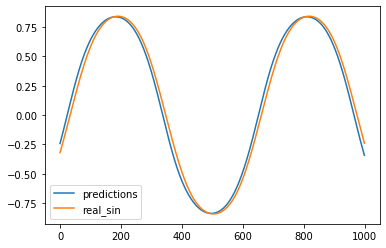

In [7]:
%matplotlib inline
plt.figure()
plt.plot(predict_result, label='predictions')
plt.plot(label_result, label='real_sin')
plt.legend()